# Drone Delivery Assignment Problem Simulator

This notebook implements a simulation system for optimizing drone delivery task assignments.

## Objectives
- Optimize task allocation among multiple delivery drones
- Analyze and evaluate performance through simulation

## Required Modules
- `dronesim`: Simulation framework for drone operations
- `DeliveryTask`: Task management for delivery operations  
- `DeliveryDrone`: Drone modeling and control
- `numpy`: Numerical computing library

In [1]:
# Import required modules for drone simulation
from dronesim import Simulator
from dronesim.energy import WattHour
from dronesim.energy.battery import BatteryStatus
from dronesim.geo import GeoPoint, Latitude, Longitude
from dronesim.mission import DeliveryTask
from dronesim.unit import ClockTime, Hour, Kilometer, KilometersPerHour, Minute, Time, Watt
from dronesim.vehicles import DeliveryDrone

DATA_CSV_FILE = "./train.csv"
EXPECT_CSV_FILE = "./train.csv"
CLUSTER_DATA_FILE = "./train.csv"

# DATA_CSV_FILE = "./test.csv"
# EXPECT_CSV_FILE = "./Sample_Submission.csv"
# CLUSTER_DATA_FILE = "./train.csv"

N_CLUSTERS = 10
WAITING_TIME = Minute(0.1)
DT = Minute(0.1)
DRONE_COUNT = 300

J = 3
BATCH_SIZE = 100

DRONE_VELOCITY = KilometersPerHour(60)
BATTERY_CAPACITY = WattHour(5000)
BATTERY_CURRENT = WattHour(5000)

IDLE_POWER = Watt(10)
VTOL_POWER = Watt(500)
TRAINSIT_POWER = Watt(500)

TASK_QUEUE_PER_DRONE=2
DELVIERYS_PER_CHARGE=2





print("All modules imported successfully!")

All modules imported successfully!


## Implement Delivery Drone Assignments Problem Simulator


In [2]:
# Define the main simulation class for drone assignments
class DroneAssignmentsProblemSimulator(Simulator[DeliveryDrone, DeliveryTask]):
    target_city : str
    target_center: GeoPoint
    target_geo_range: Kilometer
    drone_count: int
    cluster_data_path: str
    cluster: int

    def __init__(self,cluster_data_path: str, drone_count: int = 50, cluster:int =1) -> None:
        super().__init__()
        self.target_city = "Metropolitian"

        self.cluster_data_path = cluster_data_path
        self.cluster = cluster
        self._is_clustering_done = False

        target_res_lat = Latitude(12.959861)  # Example latitude for restaurant
        target_res_lon = Longitude(77.579225)  # Example longitude for restaurant
        self.target_center = GeoPoint(target_res_lat, target_res_lon)

        self.target_geo_range = Kilometer(50)  # 50 km range
        self.drone_count = drone_count

    def make_task(self, columns: list[str], row: list[str]) -> DeliveryTask | None:
        """Create a delivery task from CSV data row."""
        if "NaN" in row:
            return None

        restaurant_lat = Latitude(float(row[columns.index("Restaurant_latitude")]))
        restaurant_lon = Longitude(float(row[columns.index("Restaurant_longitude")]))

        delivery_lat = Latitude(float(row[columns.index("Delivery_location_latitude")]))
        delivery_lon = Longitude(float(row[columns.index("Delivery_location_longitude")]))


        origin = GeoPoint(
            restaurant_lat, restaurant_lon
        )
        destination = GeoPoint(
            delivery_lat, delivery_lon
        )
        if origin.distance_to(self.target_center) > self.target_geo_range:
            return None
        if destination.distance_to(self.target_center) > self.target_geo_range:
            return None

        request_time = ClockTime.from_str(row[columns.index("Time_Orderd")])
        if request_time < Hour(3):
            request_time += Hour(24)

        pickup_time = ClockTime.from_str(row[columns.index("Time_Order_picked")])
        id = int(row[columns.index("ID")], 16)
        return DeliveryTask(
            origin=origin,
            destination=destination,
            order_time=request_time,
            pickup_time=pickup_time,
            id=id,
        )

    def _get_bases(self, cluster:int) -> list[tuple[GeoPoint, float]]:
        """Get clustering bases using simple K-means instead of KMedoids to avoid haversine issues."""
        if self._is_clustering_done:
            return self._cached_bases

        try:
            import numpy as np
            from sklearn.cluster import KMeans

            tasks = self.parse_task_data(self.cluster_data_path, key=None)

            # Extract lat/lon coordinates
            points = np.array([[float(task.origin.latitude), float(task.origin.longitude)] for task in tasks])
            print(f"Clustering {len(points)} points into {self.cluster} clusters")

            # Use simple K-means with Euclidean distance (good enough for small geographic areas)
            kmeans = KMeans(n_clusters=min(self.cluster, len(points)), random_state=42, n_init=10)
            labels = kmeans.fit_predict(points)
            centers = kmeans.cluster_centers_

            retval = []
            for i, center in enumerate(centers):
                count = sum(1 for label in labels if label == i)
                if count > 0:  # Only include clusters with actual points
                    latitude = Latitude.from_si(center[0])
                    longitude = Longitude.from_si(center[1])
                    retval.append((GeoPoint(latitude, longitude), count))

            self._cached_bases = retval
            self._is_clustering_done = True
            print(f"Successfully created {len(retval)} cluster bases: ")
            for base, count in retval:
                print(f'({base.latitude}, {base.longitude}) - Store Count: {count}')
            return retval

        except Exception as e:
            print(f"Clustering failed: {e}")
            # Simple fallback: create evenly spaced points around the center
            retval = []
            for i in range(self.cluster):
                # Create points in a circle around the center
                angle = (2 * np.pi * i) / self.cluster
                offset_lat = 0.01 * np.cos(angle)  # Small offset ~1km
                offset_lon = 0.01 * np.sin(angle)

                lat = float(self.target_center.latitude) + offset_lat
                lon = float(self.target_center.longitude) + offset_lon

                retval.append((GeoPoint(Latitude(lat), Longitude(lon)), 100))  # Assume equal distribution

            self._cached_bases = retval
            self._is_clustering_done = True
            return retval

    def make_vehicle(self):
        """Generate delivery drone instances for the simulation fleet."""
        try:
            bases = self._get_bases(self.cluster)
            total_tasks = sum(count for _, count in bases)

            if total_tasks == 0:
                # Fallback: create all drones at center if clustering fails
                for i in range(self.drone_count):
                    yield DeliveryDrone(
                        pos=self.target_center,
                        velocity=DRONE_VELOCITY,
                        battery=BatteryStatus(
                            capacity=BATTERY_CAPACITY,
                            current=BATTERY_CURRENT
                        ),
                        power_idle=IDLE_POWER,
                        power_vtol=VTOL_POWER,
                        power_transit=TRAINSIT_POWER,
                        deliveries_per_charge=DELVIERYS_PER_CHARGE,
                        max_task_queue_size=TASK_QUEUE_PER_DRONE
                    )
                return

            drones_created = 0
            last_base = self.target_center

            for base, count in bases:
                # Calculate proportional drone count for this base
                base_drone_count = int((count / total_tasks) * self.drone_count)

                for i in range(base_drone_count):
                    if drones_created < self.drone_count:
                        yield DeliveryDrone(
                            pos=base,
                            velocity=DRONE_VELOCITY,
                            battery=BatteryStatus(
                                capacity=BATTERY_CAPACITY,
                                current=BATTERY_CURRENT
                            ),
                            power_idle=IDLE_POWER,
                            power_vtol=VTOL_POWER,
                            power_transit=TRAINSIT_POWER,
                            deliveries_per_charge=DELVIERYS_PER_CHARGE,
                            max_task_queue_size=TASK_QUEUE_PER_DRONE
                        )
                        drones_created += 1

                last_base = base

            # Create remaining drones at the last base
            while drones_created < self.drone_count:
                yield DeliveryDrone(
                    pos=last_base,
                    velocity=DRONE_VELOCITY,
                    battery=BatteryStatus(
                        capacity=BATTERY_CAPACITY,
                        current=BATTERY_CURRENT
                    ),
                    power_idle=IDLE_POWER,
                    power_vtol=VTOL_POWER,
                    power_transit=TRAINSIT_POWER,
                    deliveries_per_charge=DELVIERYS_PER_CHARGE,
                    max_task_queue_size=TASK_QUEUE_PER_DRONE
                )
                drones_created += 1

        except Exception as e:
            print(f"Warning: Clustering failed ({e}), using fallback drone creation")
            # Fallback: create all drones at center
            for i in range(self.drone_count):
                yield DeliveryDrone(
                    pos=self.target_center,
                    velocity=DRONE_VELOCITY,
                    battery=BatteryStatus(
                        capacity=BATTERY_CAPACITY,
                        current=BATTERY_CURRENT
                    ),
                    power_idle=IDLE_POWER,
                    power_vtol=VTOL_POWER,
                    power_transit=TRAINSIT_POWER,
                    deliveries_per_charge=DELVIERYS_PER_CHARGE,
                    max_task_queue_size=TASK_QUEUE_PER_DRONE
                )

        return None

In [3]:
from dronesim.energy.unit import Energy
from dronesim.mission.task_delivery import DeliveryState
from dronesim.simulator import (
    analyze_task_processing_speed,
    analyze_task_processing_times,
    analyze_vehicle_battery_consumption,
)
from dronesim.unit.unit_time import Hour
import matplotlib.pyplot as plt


class SimPlot:
    def __init__(self, simulator: Simulator, sample_submission_csv: str| None =None):
        self.simulator = simulator
        self.sample_submission_csv = sample_submission_csv



    def deviation_in_time_taken(self):
        import csv

        tasks: list[DeliveryTask]
        tasks, _ = self.simulator.results  # 메서드 호출, 튜플

        task_data = []
        traffic_data = []
        matched_count = 0
        total_tasks = len(tasks)

        print(f"Total simulation tasks: {total_tasks}")

        with open(self.sample_submission_csv) as f:
            reader = csv.reader(f)
            columns = next(reader)
            for row in reader:
                row = [cell.strip() for cell in row]
                row_id = int(row[columns.index("ID")], 16)

                # Find matching task
                task = None
                for t in tasks:
                    if t.id == row_id:
                        task = t
                        matched_count += 1
                        break

                if task is None:
                    continue

                # Check if task has required timing data
                if task.start_at is None or task.completed_at is None:
                    print(f"Task {task.id} missing timing data: start_at={task.start_at}, completed_at={task.completed_at}")
                    continue

                start_time = float(task.start_at)

                # Calculate simulation processing time (in minutes)
                sim_processing_time = (float(task.completed_at) - start_time)
                try:
                    request_time = ClockTime.from_str(row[columns.index("Time_Orderd")])
                    pickup_time = ClockTime.from_str(row[columns.index("Time_Order_picked")])
                    wating_time = float(pickup_time - request_time)
                except:
                    wating_time = float(Minute(10))
                if wating_time < 0:
                    wating_time = -(wating_time + float(Hour(24)))

                expected_time = float(row[columns.index("Time_taken(min)")]) * 60 + wating_time



                # Calculate deviation (expected - actual)
                time_deviation = expected_time - sim_processing_time

                task_data.append({
                    'start_time': start_time,
                    'processing_time': time_deviation
                })
                traffic = row[columns.index("Road_traffic_density")]
                traffic_data.append({
                    'start_time': start_time,
                    'congestion_level': traffic
                })

        # print(f"Matched tasks: {matched_count}")
        # print(f"Valid data points: {len(task_data)}")

        if len(task_data) == 0:
            print("No valid data found - checking first few tasks...")
            for i, task in enumerate(tasks[:5]):
                print(f"Task {i}: id={task.id}, start_at={task.start_at}, completed_at={task.completed_at}")

        return analyze_task_processing_times(task_data, "Time Deviation Analysis", traffic_data)


    def expected_time_analysis(self):
        """Analyze expected processing times from the sample submission CSV."""
        import csv

        tasks: list[DeliveryTask]
        tasks, _ = self.simulator.results  # 메서드 호출, 튜플

        task_data = []
        traffic_data = []

        matched_count = 0
        total_tasks = len(tasks)

        with open(self.sample_submission_csv) as f:
            reader = csv.reader(f)
            columns = next(reader)
            for row in reader:
                row = [cell.strip() for cell in row]
                row_id = int(row[columns.index("ID")], 16)

                # Find matching task
                task = None
                for t in tasks:
                    if t.id == row_id:
                        task = t
                        matched_count += 1
                        break

                if task is None:
                    continue

                # Check if task has required timing data
                if task.start_at is None or task.completed_at is None:
                    continue

                # Get expected time from CSV (in minutes) and convert to seconds
                try:
                    request_time = ClockTime.from_str(row[columns.index("Time_Orderd")])
                    pickup_time = ClockTime.from_str(row[columns.index("Time_Order_picked")])
                    wating_time = float(pickup_time - request_time)
                except:
                    wating_time = float(Minute(10))


                if wating_time < 0:
                    wating_time = -(wating_time + float(Hour(24)))

                expected_time = float(row[columns.index("Time_taken(min)")]) * 60 + wating_time


                task_data.append({
                    'start_time': float(task.start_at),
                    'processing_time': expected_time  # Now in seconds for consistency
                })
                traffic = row[columns.index("Road_traffic_density")]
                traffic_data.append({
                    'start_time': float(task.start_at),
                    'congestion_level': traffic
                })

        # print(f"Expected time data points: {len(task_data)}")
        return analyze_task_processing_times(task_data, "Expected Time Analysis", traffic_data)


    def task_processing_times(self):
        tasks : list[DeliveryTask]
        tasks, _ = self.simulator.results  # 메서드 호출, 튜플 언패킹 제거
        task_data = []
        for task in tasks:
            if task.start_at is not None and task.completed_at is not None:
                start_time = float(task.start_at)
                processing_time = float(task.completed_at) - start_time

                task_data.append({
                    'start_time': start_time,
                    'processing_time': processing_time
                })

        return analyze_task_processing_times(task_data, "Task Processing Time Analysis")

    def task_speed(self):
        tasks : list[DeliveryTask]
        tasks, _ = self.simulator.results  # 메서드 호출, 튜플 언패킹 제거
        task_data = []
        for task in tasks:
            if task.start_at is not None and task.completed_at is not None:
                start_time = float(task.start_at)
                t = float(task.event_time[DeliveryState.SERVICE_DROPOFF]) - float(task.event_time[DeliveryState.SERVICE_PICKUP])
                speed = (float(task.origin.distance_to(task.destination))) / (t)  # km/h


                task_data.append({
                    'start_time': start_time,
                    'speed': speed
                })

        return analyze_task_processing_speed(task_data, "Task Processing Speed Analysis")

    def deviation_speed(self):
        import csv

        tasks: list[DeliveryTask]
        tasks, _ = self.simulator.results  # 메서드 호출, 튜플

        task_data = []
        traffic_data =[]
        matched_count = 0
        total_tasks = len(tasks)

        print(f"Total simulation tasks: {total_tasks}")

        with open(self.sample_submission_csv) as f:
            reader = csv.reader(f)
            columns = next(reader)
            for row in reader:
                row = [cell.strip() for cell in row]
                row_id = int(row[columns.index("ID")], 16)

                # Find matching task
                task = None
                for t in tasks:
                    if t.id == row_id:
                        task = t
                        matched_count += 1
                        break

                if task is None:
                    continue

                # Check if task has required timing data
                if task.start_at is None or task.completed_at is None:
                    print(f"Task {task.id} missing timing data: start_at={task.start_at}, completed_at={task.completed_at}")
                    continue

                start_time = float(task.start_at)

                # Calculate simulation processing time (in minutes)
                sim_delivery_time = (float(task.event_time[DeliveryState.SERVICE_DROPOFF]) - float(task.event_time[DeliveryState.SERVICE_PICKUP]))
                # Get expected time from CSV (already in minutes)

                expected_time = float(row[columns.index("Time_taken(min)")]) * 60

                distance = float(task.origin.distance_to(task.destination))
                epceted_speed = distance / expected_time
                sim_speed = distance / sim_delivery_time

                # Calculate deviation (expected - actual)
                speed = sim_speed - epceted_speed

                task_data.append({
                    'start_time': start_time,
                    'speed': speed
                })
                traffic = row[columns.index("Road_traffic_density")]
                traffic_data.append({
                    'start_time': float(task.start_at),
                    'congestion_level': traffic
                })

        # print(f"Matched tasks: {matched_count}")
        # print(f"Valid data points: {len(task_data)}")

        if len(task_data) == 0:
            print("No valid data found - checking first few tasks...")
            for i, task in enumerate(tasks[:5]):
                print(f"Task {i}: id={task.id}, start_at={task.start_at}, completed_at={task.completed_at}")

        return analyze_task_processing_speed(task_data, "Speed Deviation Analysis", traffic_data)

    def battery_usage(self):
        tasks: list[DeliveryTask]
        vehicles: list[DeliveryDrone]
        tasks, vehicles = self.simulator.results  # 메서드 호출, 튜플
        battery_usage_history: list[tuple[Time, Time, Energy]] = []
        vehicle_data = []
        for history in [vehicle.battery_usage_history for vehicle in vehicles]:
            battery_usage_history += history

        for battery_usage in battery_usage_history:
            vehicle_data.append({
                'start_time': float(battery_usage[0]),
                'battery_used': float(battery_usage[2])
            })

        return analyze_vehicle_battery_consumption(vehicle_data, "Vehicle Battery Consumption Analysis")


    def show(self):
        plt.show()




## Fair Drone Assignment Strategy - Round-Robin Algorithm

### Algorithm Type: **Round-Robin Scheduling/Load Balancing**

The Fair Drone Assignment Strategy implements a **Round-Robin Load Balancing Algorithm** that ensures equitable task distribution among all drones in the fleet.

### How it works:
1. **Cyclic Assignment**: The algorithm maintains a counter (`drone_i`) that cycles through all available drones in sequential order
2. **Time-Based Batching**: Tasks are processed in batches at regular intervals (default: 1 minute waiting time)
3. **Fair Distribution**: Each drone gets assigned tasks in turn, ensuring equal workload distribution

### Key Characteristics:

**Fairness**: 
- Each drone receives an equal number of tasks over time
- No drone is overloaded while others remain idle
- Ensures balanced resource utilization across the fleet

**Simplicity**: 
- No complex optimization calculations required
- O(1) time complexity for task assignment
- Easy to implement and maintain

**Predictability**: 
- Deterministic assignment pattern
- Each drone knows it will receive tasks in regular intervals

### Algorithm Steps:
1. Wait for the specified time interval (`waiting_time`)
2. Get all pending delivery tasks
3. For each task:
   - Assign to the current drone (`drone_i`)
   - If assignment fails (drone is full), stop processing
   - Move to next drone: `drone_i = (drone_i + 1) % total_drones`
4. Repeat the cycle

### Use Cases:
- **Fair resource allocation** in multi-drone systems
- **Load balancing** for delivery services
- **Equal opportunity scheduling** where fairness is prioritized over optimization
- Scenarios where **simple, predictable behavior** is preferred over complex optimization

### Trade-offs:
**Advantages:**
- Guarantees fairness and equal workload
- Simple implementation and debugging
- Predictable system behavior

**Disadvantages:**
- May not be optimal for distance/time efficiency
- Doesn't consider drone proximity to tasks
- May result in longer delivery times compared to location-based algorithms

This algorithm is ideal when you want to ensure **equitable workload distribution** among drones rather than optimizing for shortest delivery times or distances.from dronesim.unit import Minute

In [4]:
class FairDroneAssignmentStrategy(DroneAssignmentsProblemSimulator):
    drone_i: int
    current: Time

    def __init__(self, drone_count: int = 50, wating_time: Time = Minute(1)):
        super().__init__(CLUSTER_DATA_FILE, drone_count, N_CLUSTERS)
        self.drone_i = 0
        self.current = wating_time
        self.wating_time = wating_time

    def sim_update(self, dt, now):
        """Update the simulation state by a time step."""
        if now < self.current:
            return
        self.current += self.wating_time

        for task in self.get_pending_tasks():
            if not self.get_vehicles()[self.drone_i].assign(task):
                self.failed_to_assign_task(task)
                break
            self.drone_i = (self.drone_i + 1) % len(self.get_vehicles())


    def sim_post_update(self, dt, now):
        """Perform any necessary operations after the simulation update."""
        pass


In [5]:
# # Run Fair Drone Assignment Strategy simulation
# fair_sim = FairDroneAssignmentStrategy(DRONE_COUNT, wating_time=WATING_TIME)
# fair_sim.run(DATA_CSV_FILE, lambda task: task.order_time, j = J, dt = DT)
# p = SimPlot(fair_sim, EXPECT_CSV_FILE)
# p.task_processing_times()
# p.expected_time_analysis()
# p.deviation_in_time_taken()
# p.task_speed()
# p.deviation_speed()
# p.show()


## Nearest Drone Assignment Strategy - Greedy Distance-Based Algorithm

### Algorithm Type: **Greedy Nearest Neighbor Assignment**

The Nearest Drone Assignment Strategy implements a **Distance-Based Greedy Algorithm** that assigns each task to the closest available drone based on geographical proximity to the task's origin point.

### How it works:
1. **Distance Calculation**: For each incoming task, calculate the distance from `task.origin` to all available drones
2. **Greedy Selection**: Select the drone with the minimum distance to the task's pickup location
3. **Immediate Assignment**: Assign the task to the nearest drone without considering global optimization
4. **Real-time Processing**: Tasks are processed as they arrive in the system

### Key Characteristics:

**Efficiency**: 
- Minimizes travel distance for pickup operations
- Reduces fuel consumption and delivery time
- Optimal for immediate response scenarios

**Simplicity**: 
- Straightforward distance-based decision making
- O(n) time complexity where n = number of available drones
- Easy to understand and implement

**Locality**: 
- Prioritizes geographical proximity
- Natural clustering of drone operations
- Efficient use of local drone resources

### Algorithm Steps:
1. Receive a new delivery task
2. Calculate distance from `task.origin` to each available drone's current position
3. Find the drone with minimum distance: `min(distance(drone.position, task.origin))`
4. Assign the task to the nearest drone if it has capacity
5. If nearest drone is full, try the next nearest drone
6. Repeat for all incoming tasks

### Use Cases:
- **Time-critical deliveries** where pickup speed is essential
- **Fuel-efficient operations** to minimize operational costs
- **Urban delivery services** with high task density
- **Emergency response** scenarios requiring immediate dispatch
- **Resource optimization** based on geographical distribution

### Trade-offs:
**Advantages:**
- Minimizes travel time and distance
- Reduces operational costs (fuel, battery)
- Simple and intuitive decision making
- Good performance for locally clustered tasks

**Disadvantages:**
- May create uneven workload distribution among drones
- Can lead to some drones being overworked while others are idle
- Doesn't consider future task arrivals or global optimization
- May not be optimal for long-term system efficiency

### Mathematical Foundation:
```
For task T with origin O, select drone D where:
D* = argmin(distance(D.position, T.origin)) for all available drones D
```

This algorithm is ideal when **minimizing delivery response time** and **operational costs** are more important than ensuring perfectly balanced workload distribution among the drone fleet.

In [6]:
class NearestDroneAssignmentStrategy(DroneAssignmentsProblemSimulator):
    """Nearest Drone Assignment Strategy implementing Greedy Distance-Based Algorithm.
    Assigns each task to the closest available drone based on geographical proximity.
    """

    def __init__(self, drone_count: int = 50, wating_time: Time = Minute(1)):
        super().__init__(CLUSTER_DATA_FILE, drone_count, N_CLUSTERS)
        self.current = wating_time
        self.wating_time = wating_time

    def sim_update(self, dt, now):
        """Update the simulation state by assigning tasks to nearest available drones."""
        if now < self.current:
            return
        self.current += self.wating_time

        for task in self.get_pending_tasks():
            # Find the nearest available drone to the task's origin
            nearest_drone = self._find_nearest_drone(task)

            if nearest_drone is not None:
                # Try to assign the task to the nearest drone
                if not nearest_drone.assign(task):
                    # If nearest drone is full, try other drones in order of distance
                    if not self._assign_to_alternative_drone(task):
                        self.failed_to_assign_task(task)
                        break
            else:
                self.failed_to_assign_task(task)
                break

    def _find_nearest_drone(self, task: DeliveryTask):
        """Find the drone with minimum distance to the task's origin."""
        # Only consider operational drones (not full and has battery)
        available_drones = [drone for drone in self.get_vehicles() if drone.is_operational()]

        if not available_drones:
            return None

        # Calculate distances and find the nearest drone
        min_distance = None
        nearest_drone = None

        for drone in available_drones:
            distance = drone.position.distance_to(task.origin)
            if min_distance is None or distance < min_distance:
                min_distance = distance
                nearest_drone = drone

        return nearest_drone

    def _assign_to_alternative_drone(self, task: DeliveryTask):
        """Try to assign task to alternative drones if nearest is unavailable."""
        # Get all operational drones sorted by distance to task origin
        available_drones = [drone for drone in self.get_vehicles() if drone.is_operational()]
        drone_distances = []

        for drone in available_drones:
            distance = drone.position.distance_to(task.origin)
            drone_distances.append((drone, distance))

        # Sort by distance (ascending) - using float conversion for sorting
        drone_distances.sort(key=lambda x: float(x[1]))

        # Try to assign to drones in order of proximity
        for drone, _ in drone_distances:
            if drone.assign(task):
                return True
        return False

    def sim_post_update(self, dt, now):
        """Perform any necessary operations after the simulation update."""
        pass

In [7]:
# # Run Nearest Drone Assignment Strategy simulation
# nearest_sim = NearestDroneAssignmentStrategy(DRONE_COUNT, wating_time=WATING_TIME)
# nearest_sim.run(DATA_CSV_FILE, lambda task: task.order_time, j = J, dt = DT)
# p_nearest = SimPlot(nearest_sim, EXPECT_CSV_FILE)
# p_nearest.task_processing_times()
# p_nearest.expected_time_analysis()
# p_nearest.deviation_in_time_taken()
# p_nearest.task_speed()
# p_nearest.deviation_speed()
# p_nearest.show()

In [8]:
# Nearest Strategy - Expected Time Analysis
# p_nearest.expected_time_analysis()

## Optimal Distance Assignment Strategy - Smart Route Optimization Algorithm

### Algorithm Type: **Dynamic Route Optimization with Total Distance Minimization**

The Optimal Distance Assignment Strategy implements a **Smart Route Optimization Algorithm** that considers not only the distance to the new task's pickup location, but also the total additional travel distance when the new task is integrated into each drone's existing task queue.

### How it works:
1. **Queue Analysis**: For each drone, analyze its current task queue and planned route
2. **Route Integration**: Calculate the optimal insertion point for the new task in each drone's route
3. **Distance Calculation**: Compute the total additional distance required when inserting the new task
4. **Optimal Selection**: Choose the drone that results in the minimum total additional travel distance
5. **Dynamic Insertion**: Insert the task at the optimal position in the selected drone's queue

### Key Characteristics:

**Intelligence**: 
- Considers existing workload and routing context
- Optimizes for total system efficiency rather than just proximity
- Dynamically adapts to current operational state

**Efficiency**: 
- Minimizes total fleet travel distance
- Reduces overall fuel consumption and delivery time
- Optimizes resource utilization across the entire system

**Adaptability**: 
- Adjusts decisions based on real-time drone states
- Considers current task queues and planned routes
- Responds to varying operational conditions

### Algorithm Steps:
1. Receive a new delivery task T
2. For each operational drone D:
   - Get current task queue: [T₁, T₂, ..., Tₙ]
   - Calculate current planned route distance: `route_distance(current_queue)`
   - For each possible insertion position i (0 to n+1):
     - Create new queue: [T₁, ..., Tᵢ, T, Tᵢ₊₁, ..., Tₙ]
     - Calculate new route distance: `route_distance(new_queue)`
     - Compute additional distance: `additional_distance = new_route - current_route`
   - Record minimum additional distance for drone D
3. Select drone with minimum additional distance: `D* = argmin(additional_distance(D, T))`
4. Insert task T at the optimal position in D*'s queue

### Use Cases:
- **Fleet optimization** where total operational cost is critical
- **High-density delivery services** with multiple concurrent tasks per drone
- **Resource-constrained environments** where efficiency is paramount
- **Complex urban delivery networks** with varying distances and traffic patterns
- **Long-term operational optimization** focusing on system-wide performance

### Mathematical Foundation:
```
For task T and drone D with current queue Q = [T₁, T₂, ..., Tₙ]:

Current route distance:
R(Q) = distance(drone_pos, T₁) + Σ(distance(Tᵢ.destination, Tᵢ₊₁.origin)) + distance(Tₙ.destination, drone_pos)

For insertion at position i:
Q' = [T₁, ..., Tᵢ, T, Tᵢ₊₁, ..., Tₙ]
Additional distance = R(Q') - R(Q)

Optimal assignment:
D* = argmin(min_insertion_position(additional_distance(D, T))) for all drones D
```

### Trade-offs:
**Advantages:**
- Globally optimized route planning
- Minimizes total system operational costs
- Considers real-time operational context
- Better long-term efficiency than greedy approaches
- Intelligent task queue management

**Disadvantages:**
- Higher computational complexity O(n×m×k) where n=drones, m=avg_queue_size, k=insertion_positions
- More complex implementation and debugging
- May have longer initial response times due to optimization calculations
- Requires maintaining detailed state information for all drones

### Comparison with Other Strategies:

**vs Fair Assignment:**
- More efficient but potentially less balanced workload
- Considers route optimization vs simple round-robin

**vs Nearest Assignment:**
- More intelligent but computationally more expensive
- Considers entire route context vs just pickup proximity

**vs All Strategies:**
- Highest optimization potential for total system efficiency
- Best suited for scenarios where operational cost minimization is the primary goal

This algorithm is ideal when **minimizing total operational costs** and **maximizing system-wide efficiency** are more important than simplicity or guaranteed workload balance. It's particularly effective in scenarios with high task density and complex routing requirements.

In [9]:
class OptimalDistanceAssignmentStrategy(DroneAssignmentsProblemSimulator):
    """Nearest Drone Assignment Strategy implementing Greedy Distance-Based Algorithm.
    Assigns each task to the closest available drone based on geographical proximity.
    """

    def __init__(self, drone_count: int = 50, wating_time: Time = Minute(1)):
        super().__init__(CLUSTER_DATA_FILE, drone_count, N_CLUSTERS)
        self.current = wating_time
        self.wating_time = wating_time

    def sim_update(self, dt, now):
        """Update the simulation state by assigning tasks to nearest available drones."""
        if now < self.current:
            return
        self.current += self.wating_time

        for task in self.get_pending_tasks():
            # Find the nearest available drone to the task's origin
            if not self._find_optimal_drone(task):
                self.failed_to_assign_task(task)
                break

    def _find_optimal_drone(self, task: DeliveryTask):
        """Find the drone with minimum distance to the task's origin."""
        # Only consider operational drones (not full and has battery)
        available_drones = [drone for drone in self.get_vehicles() if drone.is_operational()]
        if len(available_drones) == 0:
            return False

        drone_distances = []

        for drone in available_drones:
            distance, last_point = drone.route_remainder(task)
            d_distance = distance - drone.route_remainder()[0]
            drone_distances.append((drone, distance, d_distance))

        # Sort by distance (ascending) - using float conversion for sorting
        drone_distances.sort(key=lambda x: float(x[1]))

        # Try to assign to drones in order of proximity
        for drone, _, d_distance in drone_distances:
            if drone.assign(task):
                return True
        return False

    def sim_post_update(self, dt, now):
        """Perform any necessary operations after the simulation update."""
        pass

Output()

Clustering 2878 points into 10 clusters

Successfully created 10 cluster bases:

(12.9793 °N/S, 77.6414 °E/W) - Store Count: 575

(12.9499 °N/S, 77.6994 °E/W) - Store Count: 150

(12.9341 °N/S, 77.6152 °E/W) - Store Count: 730

(13.0292 °N/S, 77.571 °E/W) - Store Count: 155

(12.9724 °N/S, 77.6023 °E/W) - Store Count: 277

(12.9137 °N/S, 77.6808 °E/W) - Store Count: 280

(12.9062 °N/S, 77.5968 °E/W) - Store Count: 133

(12.9754 °N/S, 77.6967 °E/W) - Store Count: 143

(12.9703 °N/S, 77.6456 °E/W) - Store Count: 297

(12.9395 °N/S, 77.626 °E/W) - Store Count: 138

╭──────────────────────────────────────────────── Current States ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task - ASSIGNED:                   0                                                                           │
│  Task - GO_PICKUP:                  0                                                                           │
│  Task - SERVICE_PICKUP:             0                                                                           │
│  Task - GO_DROPOFF:                 0                                                                           │
│  Task - SERVICE_DROPOFF:            0                                                                           │
│  Task - DONE:                       2878                                                                        │
│  Task - ABORTED:                    0                                                                           │
│  Vehicle - GROUNDED:                261                                                                         │
│  Vehicle - TAKING_OFF:              0                                                                           │
│  Vehicle - NAVIGATING:              35                                                                          │
│  Vehicle - LANDING:                 4                                                                           │
│  Vehicle - EMERGENCY:               0                                                                           │
│  Average Task Time:                 00:19:28.192                                                                │
│  Task Time Standard Deviation:      00:06:59.373                                                                │
│  Max Vehicle Utilization:           78.7%                                                                       │
│  Operational Vehicles Percentage:   100.0%                                                                      │
│  Pending Queue Size:                0                                                                           │
│  Working Queue Size:                0                                                                           │
│  Completed Queue Size:              2878                                                                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

=== Task Processing Time Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
=== Task Processing Time Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
Total simulation tasks: 2878
=== Task Processing Time Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
=== Task Processing Speed Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
Total simulation tasks: 2878
=== Task Processing Speed Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
=== Vehicle Battery Consumption Analysis ===
Input data points: 2816
Valid data points for analysis: 2816


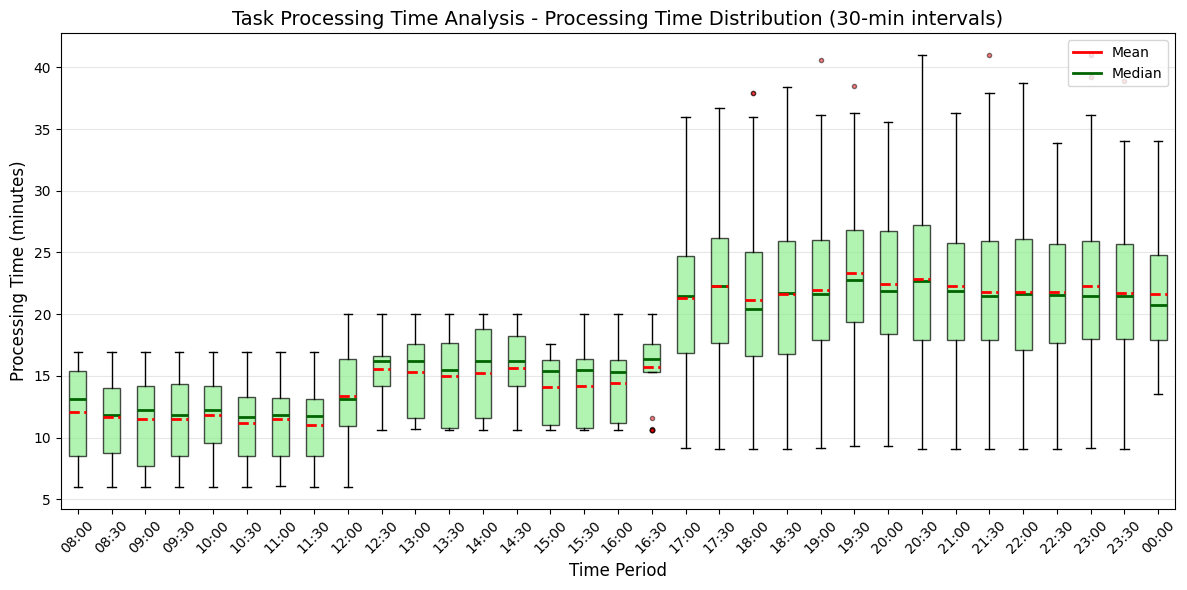

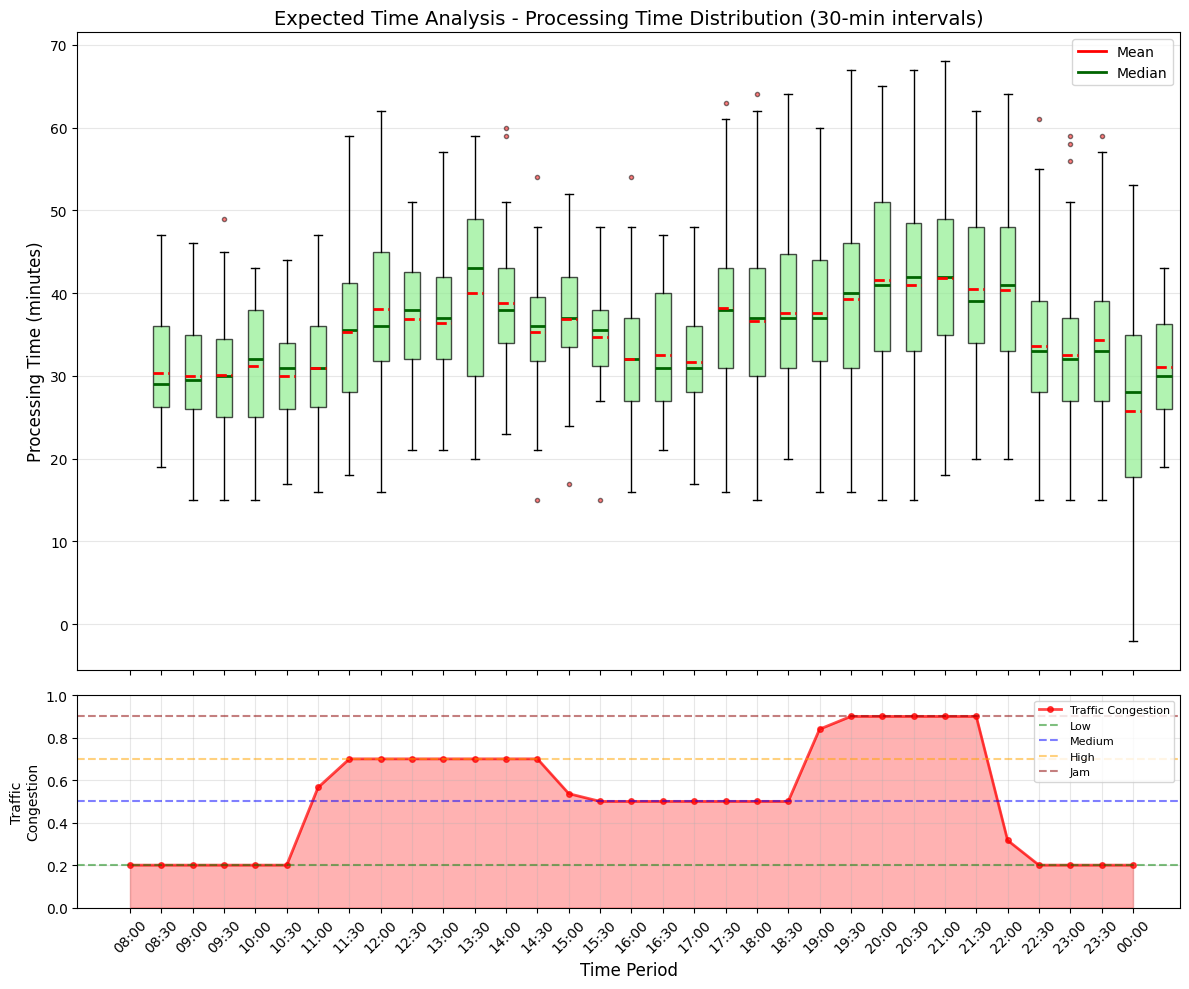

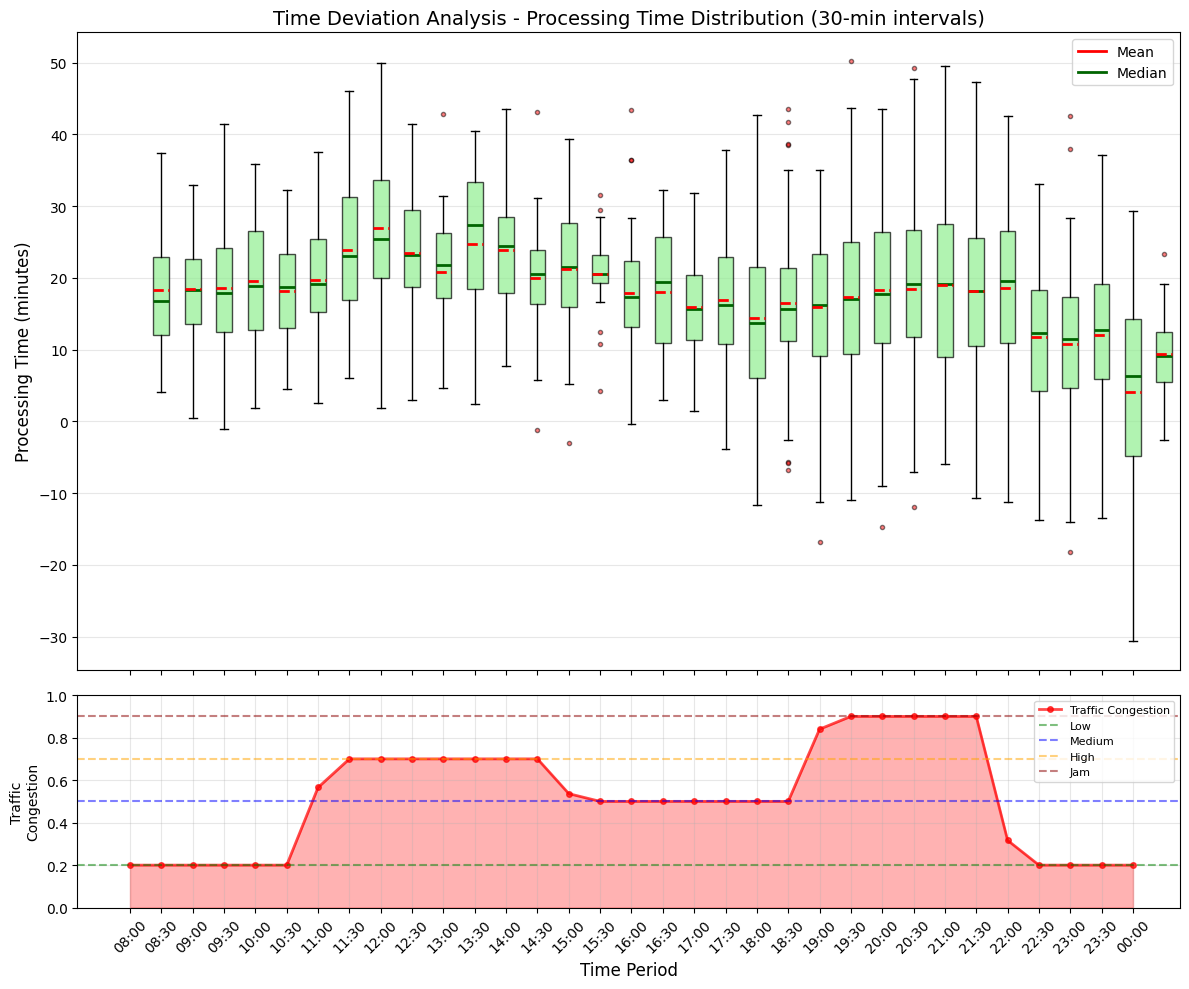

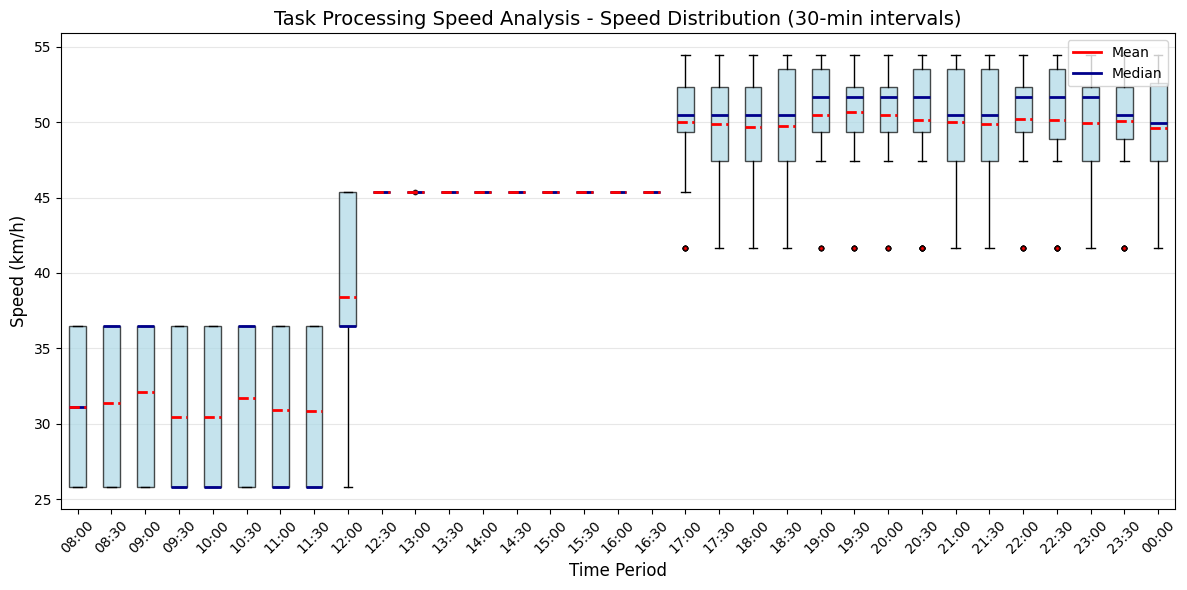

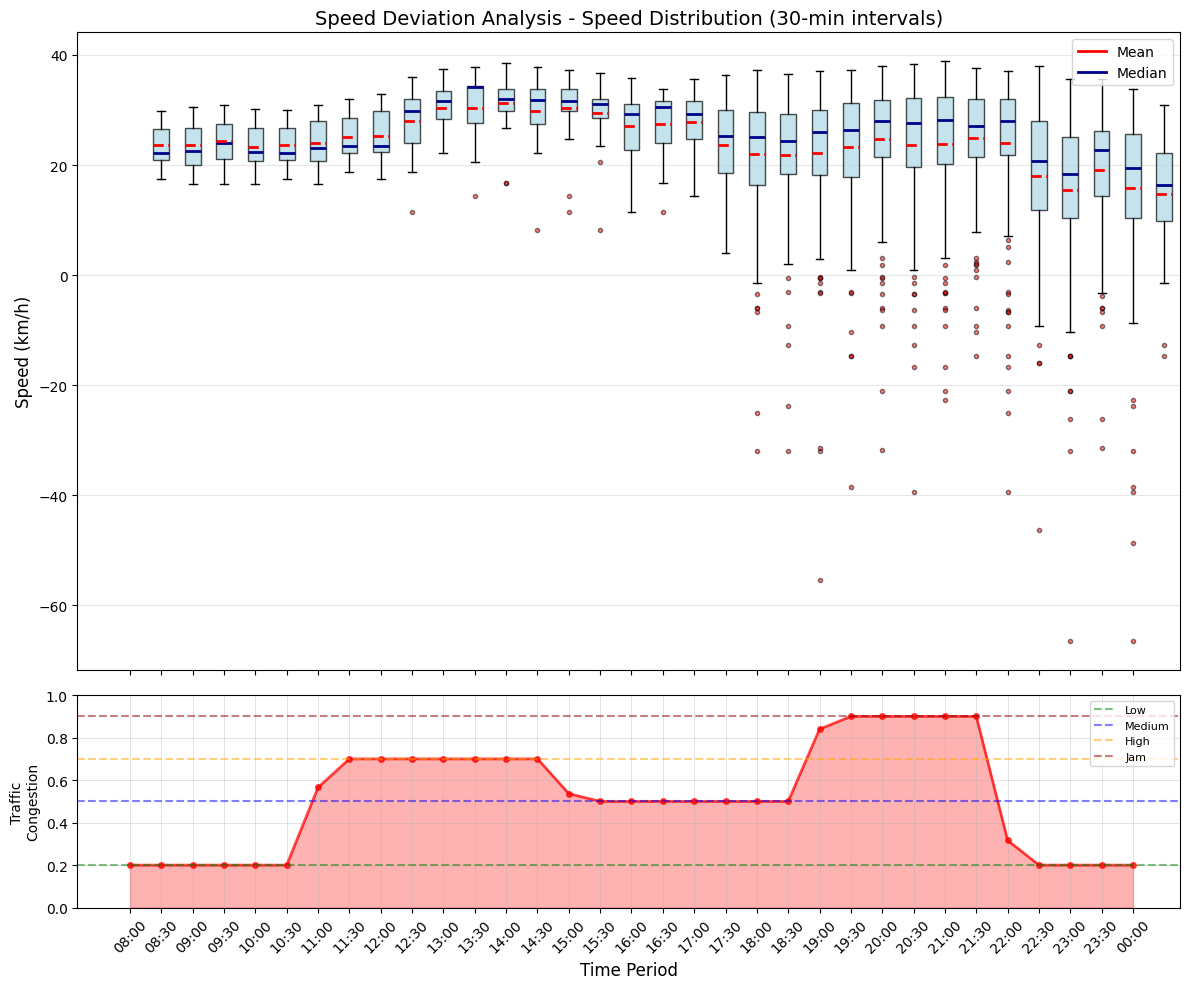

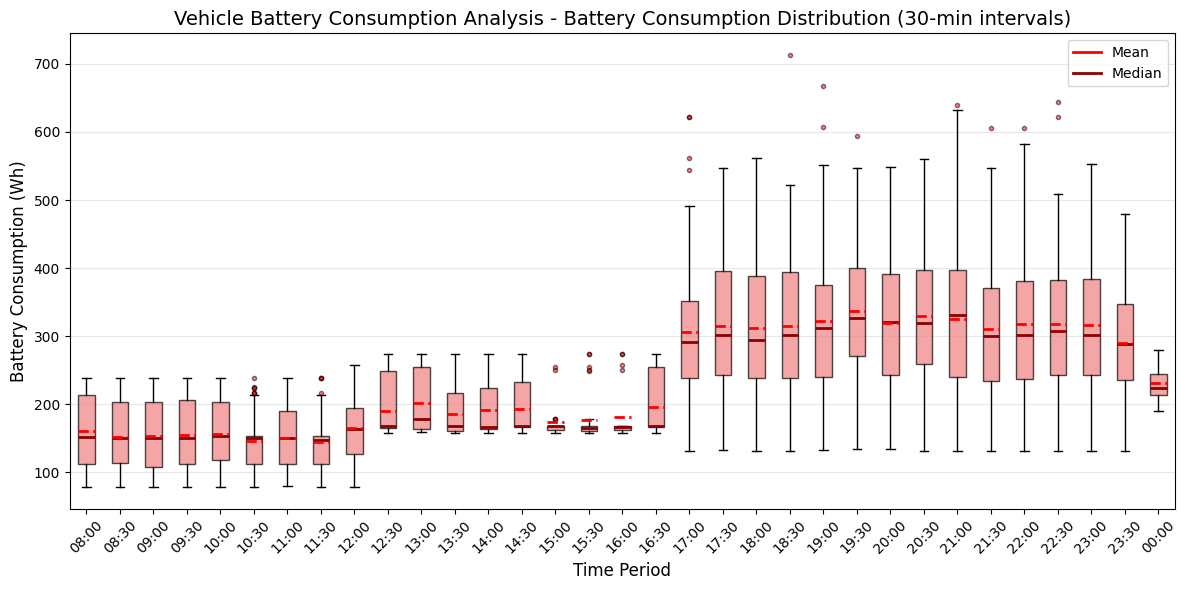

In [10]:
# Run Optimal Distance Assignment Strategy simulation
optimal_sim = OptimalDistanceAssignmentStrategy(DRONE_COUNT, wating_time=WAITING_TIME)
optimal_sim.run(DATA_CSV_FILE, lambda task: task.order_time, j = J, dt = DT, batch_size=BATCH_SIZE)
p_optimal = SimPlot(optimal_sim, EXPECT_CSV_FILE)
p_optimal.task_processing_times()
p_optimal.expected_time_analysis()
p_optimal.deviation_in_time_taken()
p_optimal.task_speed()
p_optimal.deviation_speed()
p_optimal.battery_usage()
p_optimal.show()